<a href="https://colab.research.google.com/github/linyuehzzz/census_privacy/blob/main/cell_uniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


####**Impact of geographic scales**
> Some simulations to demonstrate how geographic scales affect the probability of finding a true unique. Two aspects of spatial scales are examined here: resolution and extent.




**Read original workload query outputs**  
> We consider the query of race for the purpose of demonstration. Cell uniqueness is presented in this query.

Franklin county

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import numpy as np

n4 = 63
filename_hist1 = 'data/franklin/microdata/franklin_hist.csv'
hist1 = pd.read_csv(filename_hist1)
hist1['BLK'] = hist1['GEOID10'].astype(str)
col_names = hist1.columns.to_numpy()
col_names = np.delete(col_names, [0, -1])
hist1 = hist1.groupby('BLK').sum()[col_names]

col_two_or_more_races = []
for x in range(n4):     # race
    if x >= 0 and x <= 5:
        x = '{number:0{width}d}'.format(width=2, number=x)
        col_names = [col for col in hist1.columns if x in col[6:8]]
        hist1[str(x)] = hist1[col_names].sum(axis=1)
    else:
        x = '{number:0{width}d}'.format(width=2, number=x)
        col_names = [col for col in hist1.columns if x in col[6:8]]
        col_two_or_more_races.extend(col_names)
hist1['06'] = hist1[col_two_or_more_races].sum(axis=1)
hist1.drop([col for col in hist1.columns if len(col)==8], axis=1, inplace=True)
hist1

/content/gdrive/My Drive/Colab Notebooks/census_privacy


,00,01,02,03,04,05,06
BLK,,,,,,,
390490001101000,0,0,0,0,0,0,0
390490001101001,1,0,0,0,0,0,0
390490001101002,45,0,0,0,0,0,0
390490001101003,51,4,0,0,0,0,0
390490001101004,48,0,0,0,0,0,0
...,...,...,...,...,...,...,...
390499800001070,0,0,0,0,0,0,0
390499800001071,0,0,0,0,0,0,0
390499800001072,0,0,0,0,0,0,0


Guernsey county

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import numpy as np

n4 = 63
filename_hist1_g = 'data/guernsey/microdata/guernsey_hist.csv'
hist1_g = pd.read_csv(filename_hist1_g)
hist1_g['BLK'] = hist1_g['GEOID10'].astype(str)
col_names = hist1_g.columns.to_numpy()
col_names = np.delete(col_names, [0, -1])
hist1_g = hist1_g.groupby('BLK').sum()[col_names]

col_two_or_more_races = []
for x in range(n4):     # race
    if x >= 0 and x <= 5:
        x = '{number:0{width}d}'.format(width=2, number=x)
        col_names = [col for col in hist1_g.columns if x in col[6:8]]
        hist1_g[str(x)] = hist1_g[col_names].sum(axis=1)
    else:
        x = '{number:0{width}d}'.format(width=2, number=x)
        col_names = [col for col in hist1_g.columns if x in col[6:8]]
        col_two_or_more_races.extend(col_names)
hist1_g['06'] = hist1_g[col_two_or_more_races].sum(axis=1)
hist1_g.drop([col for col in hist1_g.columns if len(col)==8], axis=1, inplace=True)
hist1_g

/content/gdrive/My Drive/Colab Notebooks/census_privacy


,00,01,02,03,04,05,06
BLK,,,,,,,
390599771001000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390599771001001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390599771001002,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390599771001003,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390599771001004,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
390599780004093,7.0,0.0,0.0,0.0,0.0,0.0,0.0
390599780004094,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390599780004095,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Read dp workload query outputs**  

Franklin county

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import numpy as np

n4 = 63
filename_hist2 = 'data/franklin/microdata/rho_2.56/franklin_hist_dp_blk.csv'
hist2 = pd.read_csv(filename_hist2)
hist2['BLK'] = hist2['BLK'].astype(str)
col_names = hist2.columns.to_numpy()
col_names = np.delete(col_names, [0, -1])
hist2 = hist2.groupby('BLK').sum()[col_names]

col_two_or_more_races = []
for x in range(n4):     # race
    if x >= 0 and x <= 5:
        x = '{number:0{width}d}'.format(width=2, number=x)
        col_names = [col for col in hist2.columns if x in col[6:8]]
        hist2[str(x)] = hist2[col_names].sum(axis=1)
    else:
        x = '{number:0{width}d}'.format(width=2, number=x)
        col_names = [col for col in hist2.columns if x in col[6:8]]
        col_two_or_more_races.extend(col_names)
hist2['06'] = hist2[col_two_or_more_races].sum(axis=1)
hist2.drop([col for col in hist2.columns if len(col)==8], axis=1, inplace=True)
hist2

/content/gdrive/My Drive/Colab Notebooks/census_privacy


,00,01,02,03,04,05,06
BLK,,,,,,,
390490001101000,0.0,2.0,0.0,1.0,0.0,2.0,0.0
390490001101001,1.0,0.0,0.0,3.0,1.0,1.0,1.0
390490001101002,43.0,0.0,0.0,0.0,0.0,2.0,1.0
390490001101003,55.0,5.0,0.0,0.0,0.0,0.0,1.0
390490001101004,49.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
390499800001070,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390499800001071,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390499800001072,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Guernsey county

In [46]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import numpy as np

n4 = 63
filename_hist2_g = 'data/guernsey/microdata/rho_2.56/guernsey_hist_dp_blk2.csv'
hist2_g = pd.read_csv(filename_hist2_g)
hist2_g['BLK'] = hist2_g['BLK'].astype(str)
col_names = hist2_g.columns.to_numpy()
col_names = np.delete(col_names, [0, -1])
hist2_g = hist2_g.groupby('BLK').sum()[col_names]

col_two_or_more_races = []
for x in range(n4):     # race
    if x >= 0 and x <= 5:
        x = '{number:0{width}d}'.format(width=2, number=x)
        col_names = [col for col in hist2_g.columns if x in col[6:8]]
        hist2_g[str(x)] = hist2_g[col_names].sum(axis=1)
    else:
        x = '{number:0{width}d}'.format(width=2, number=x)
        col_names = [col for col in hist2_g.columns if x in col[6:8]]
        col_two_or_more_races.extend(col_names)
hist2_g['06'] = hist2_g[col_two_or_more_races].sum(axis=1)
hist2_g.drop([col for col in hist2_g.columns if len(col)==8], axis=1, inplace=True)
hist2_g

/content/gdrive/My Drive/Colab Notebooks/census_privacy


,00,01,02,03,04,05,06
BLK,,,,,,,
390599771001000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390599771001001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390599771001002,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390599771001003,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390599771001004,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
390599780004093,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390599780004094,9.0,0.0,0.0,0.0,0.0,0.0,0.0
390599780004095,12.0,0.0,0.0,0.0,0.0,0.0,0.0


#####**Impact of resolutions (aggregation levels)**
> We test the probability of finding a true unique at block, block group, and tract levels. We make comparisons among (1) our results, (2) NHGIS data from the 2021-06-08 vintage of the PPMF, and (3) the OLS estimators.



Group 1: Franklin County, my data

In [ ]:
## block
hist1_blk, hist2_blk = hist1, hist2
tu = (hist1_blk == hist2_blk) & (hist1_blk == 1) & (hist2_blk == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_blk == 1  # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_blk = n_tu / n_u   # frequency of finding the true uniques

## block group
col_names = hist1.columns.to_numpy()
hist1_bg = hist1.groupby(hist1.index.astype(str).str[:12]).sum()
hist1_bg.index.name = 'BG'
hist2_bg = hist2.groupby(hist2.index.astype(str).str[:12]).sum()
hist2_bg.index.name = 'BG'

tu = (hist1_bg == hist2_bg) & (hist1_bg == 1) & (hist2_bg == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_bg == 1  # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_bg = n_tu / n_u   # frequency of finding the true uniques

## tract
col_names = hist1.columns.to_numpy()
hist1_tr = hist1.groupby(hist1.index.astype(str).str[:11]).sum()
hist1_tr.index.name = 'TRACT'
hist2_tr = hist2.groupby(hist2.index.astype(str).str[:11]).sum()
hist2_tr.index.name = 'TRACT'

tu = (hist1_tr == hist2_tr) & (hist1_tr == 1) & (hist2_tr == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_tr == 1  # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_tr = n_tu / n_u   # frequency of finding the true uniques

print(p_tu_blk, p_tu_bg, p_tu_tr)

0.06568958245466049 0.13142857142857142 0.15384615384615385


Group 2: Franklin County, NHGIS data (2021-06-08)

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

## block
filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_block_OH.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis = data_nhgis[(data_nhgis["STATE"] == '39') & (data_nhgis["COUNTY"] == '049')]
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_blk = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_blk = hist1_nhgis_blk.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_blk = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_blk = hist2_nhgis_blk.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

tu = (hist1_nhgis_blk == hist2_nhgis_blk) & (hist1_nhgis_blk == 1) & (hist2_nhgis_blk == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_nhgis_blk == 1    # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_nhgis_blk = n_tu / n_u # frequency of finding the true uniques

## block group
filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_blck_grp.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis = data_nhgis[(data_nhgis["STATE"] == '39') & (data_nhgis["COUNTY"] == '049')]
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_bg = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_bg = hist1_nhgis_bg.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_bg = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_bg = hist2_nhgis_bg.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

tu = (hist1_nhgis_bg == hist2_nhgis_bg) & (hist1_nhgis_bg == 1) & (hist2_nhgis_bg == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_nhgis_bg == 1    # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_nhgis_bg = n_tu / n_u # frequency of finding the true uniques

## tract
filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_tract.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis = data_nhgis[(data_nhgis["STATE"] == '39') & (data_nhgis["COUNTY"] == '049')]
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_tr = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_tr = hist1_nhgis_tr.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_tr = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_tr = hist2_nhgis_tr.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

tu = (hist1_nhgis_tr == hist2_nhgis_tr) & (hist1_nhgis_tr == 1) & (hist2_nhgis_tr == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_nhgis_tr == 1    # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_nhgis_tr = n_tu / n_u # frequency of finding the true uniques

print(p_tu_nhgis_blk, p_tu_nhgis_bg, p_tu_nhgis_tr)

/content/gdrive/My Drive/Colab Notebooks/census_privacy
0.115491452991453 0.2316715542521994 0.18181818181818182


Group 3: Franklin County, OLS

> Let $A_i$ = {cell = $i$ before noise injection}, and the noise be $W\sim N(0,\sigma^2)$. A true unique (TU) is a cell = 1 before and after noise injection. The probability of finding a true unique can be defined using the Bayes' theorem:

> $p(TU)=\frac{p(W=0)p(A_1)}{\sum_ip(W=1-i)p(A_i)}$


> $p(TU)$ is large if (i) the histogram is dominantly "unique", (ii) non-unique cells have relatively large values, and/or (iii) the privacy budget is large.

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
from lib.topdown_ols import *
import scipy.stats
import math

eps = 17.14
delta = 1e-10
# rho = 1
rho = cdp2adp.cdp_rho(eps, delta)

## block
f1, f2, f3, f4, f6, f7, f8, f9, f10, f11 = 165/4099*5/4097, 165/4099*9/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*21/4097, 165/4099*21/4097, 165/4099*5/4097, 165/4099*71/4097, 165/4099*3945/4097
A = strategy_mtx(rho, f1, f2, f3, f4, f6, f7, f8, f9, f10, f11)
W = workload_mtx_race()
var = (W @ np.linalg.inv(A.T @ A) @ W.T)[0, 0]
sigma = math.sqrt(var)
column_values = hist1[hist1.columns].values.ravel()
A = pd.unique(column_values)
probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1 == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)
p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1 == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu_ols_blk = p3 * p4 / sum(probs)

## block group
col_names = hist1.columns.to_numpy()
hist1_bg = hist1.groupby(hist1.index.astype(str).str[:12]).sum()

f1, f2, f3, f4, f6, f7, f8, f9, f10, f11 = 1256/4099*1705/4099, 1256/4099*3/4099, 1256/4099*3/4099, 1256/4099*3/4099, 1256/4099*3/4099, 1256/4099*1055/4099, 1256/4099*9/4099, 1256/4099*3/4099, 1256/4099*24/4099, 1256/4099*1288/4099
A = strategy_mtx(rho, f1, f2, f3, f4, f6, f7, f8, f9, f10, f11)
W = workload_mtx_race()
var = (W @ np.linalg.inv(A.T @ A) @ W.T)[0, 0]
sigma = math.sqrt(var)

column_values = hist1_bg[hist1_bg.columns].values.ravel()
A = pd.unique(column_values)
probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_bg == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)
p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_bg == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu_ols_bg = p3 * p4 / sum(probs)

## tract
col_names = hist1.columns.to_numpy()
hist1_tr = hist1.groupby(hist1.index.astype(str).str[:11]).sum()

f1, f2, f3, f4, f6, f7, f8, f9, f10, f11 = 687/4099*1567/4102, 687/4099*4/2051, 687/4099*5/4102, 687/4099*5/4102, 687/4099*5/4102, 687/4099*1933/4102, 687/4099*10/2051, 687/4099*5/4102, 687/4099*67/4102, 687/4099*241/2051
A = strategy_mtx(rho, f1, f2, f3, f4, f6, f7, f8, f9, f10, f11)
W = workload_mtx_race()
var = (W @ np.linalg.inv(A.T @ A) @ W.T)[0, 0]
sigma = math.sqrt(var)

column_values = hist1_tr[hist1_tr.columns].values.ravel()
A = pd.unique(column_values)
probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_tr == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)
p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_tr == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu_ols_tr = p3 * p4 / sum(probs)

print(p_tu_ols_blk, p_tu_ols_bg, p_tu_ols_tr)

/content/gdrive/My Drive/Colab Notebooks/census_privacy
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
0.04809997077232813 0.1995044826450929 0.24278397521046818


Group 4: Guernsey County, my data

In [47]:
## block
hist1_blk_g, hist2_blk_g = hist1_g, hist2_g
tu = (hist1_blk_g == hist2_blk_g) & (hist1_blk_g == 1) & (hist2_blk_g == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_blk_g == 1  # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_blk_g = n_tu / n_u   # frequency of finding the true uniques

## block group
col_names = hist1_g.columns.to_numpy()
hist1_bg_g = hist1_g.groupby(hist1_g.index.astype(str).str[:12]).sum()
hist1_bg_g.index.name = 'BG'
hist2_bg_g = hist2_g.groupby(hist2_g.index.astype(str).str[:12]).sum()
hist2_bg_g.index.name = 'BG'

tu = (hist1_bg_g == hist2_bg_g) & (hist1_bg_g == 1) & (hist2_bg_g == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_bg_g == 1  # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_bg_g = n_tu / n_u   # frequency of finding the true uniques

## tract
col_names = hist1_g.columns.to_numpy()
hist1_tr_g = hist1_g.groupby(hist1_g.index.astype(str).str[:11]).sum()
hist1_tr_g.index.name = 'TRACT'
hist2_tr_g = hist2_g.groupby(hist2_g.index.astype(str).str[:11]).sum()
hist2_tr_g.index.name = 'TRACT'

tu = (hist1_tr_g == hist2_tr_g) & (hist1_tr_g == 1) & (hist2_tr_g == 1) # find a true unique
if len(np.unique(tu.values, return_counts=True)[1]) == 2:  
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    u = hist2_tr_g == 1  # uniques after noise injection
    n_u = np.unique(u.values, return_counts=True)[1][1]
    p_tu_tr_g = n_tu / n_u   # frequency of finding the true uniques
else:
    p_tu_tr_g = 0
print(p_tu_blk_g, p_tu_bg_g, p_tu_tr_g)

0.02142857142857143 0.25 0.3333333333333333


Group 5: Guernsey County, NHGIS data (2021-06-08)

In [32]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

## block
filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_block_OH.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis = data_nhgis[(data_nhgis["STATE"] == '39') & (data_nhgis["COUNTY"] == '059')]
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_blk = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_blk = hist1_nhgis_blk.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_blk = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_blk = hist2_nhgis_blk.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

tu = (hist1_nhgis_blk == hist2_nhgis_blk) & (hist1_nhgis_blk == 1) & (hist2_nhgis_blk == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_nhgis_blk == 1    # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_nhgis_blk_g = n_tu / n_u # frequency of finding the true uniques

## block group
filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_blck_grp.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis = data_nhgis[(data_nhgis["STATE"] == '39') & (data_nhgis["COUNTY"] == '059')]
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_bg = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_bg = hist1_nhgis_bg.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_bg = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_bg = hist2_nhgis_bg.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

tu = (hist1_nhgis_bg == hist2_nhgis_bg) & (hist1_nhgis_bg == 1) & (hist2_nhgis_bg == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_nhgis_bg == 1    # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_nhgis_bg_g = n_tu / n_u # frequency of finding the true uniques

## tract
filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_tract.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis = data_nhgis[(data_nhgis["STATE"] == '39') & (data_nhgis["COUNTY"] == '059')]
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_tr = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_tr = hist1_nhgis_tr.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_tr = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_tr = hist2_nhgis_tr.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

tu = (hist1_nhgis_tr == hist2_nhgis_tr) & (hist1_nhgis_tr == 1) & (hist2_nhgis_tr == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_nhgis_tr == 1    # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_nhgis_tr_g = n_tu / n_u # frequency of finding the true uniques

print(p_tu_nhgis_blk_g, p_tu_nhgis_bg_g, p_tu_nhgis_tr_g)

/content/gdrive/My Drive/Colab Notebooks/census_privacy
0.05701078582434515 0.3448275862068966 0.5


Group 6: Guernsey County, OLS

In [48]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
from lib.topdown_ols import *
import scipy.stats
import math

eps = 17.14
delta = 1e-10
# rho = 1
rho = cdp2adp.cdp_rho(eps, delta)

## block
f1, f2, f3, f4, f6, f7, f8, f9, f10, f11 = 165/4099*5/4097, 165/4099*9/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*21/4097, 165/4099*21/4097, 165/4099*5/4097, 165/4099*71/4097, 165/4099*3945/4097
A = strategy_mtx(rho, f1, f2, f3, f4, f6, f7, f8, f9, f10, f11)
W = workload_mtx_race()
var = (W @ np.linalg.inv(A.T @ A) @ W.T)[0, 0]
sigma = math.sqrt(var)
column_values = hist1_g[hist1_g.columns].values.ravel()
A = pd.unique(column_values)
probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_g == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)
p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_g == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu_ols_blk_g = p3 * p4 / sum(probs)

## block group
col_names = hist1_g.columns.to_numpy()
hist1_bg_g = hist1_g.groupby(hist1_g.index.astype(str).str[:12]).sum()

f1, f2, f3, f4, f6, f7, f8, f9, f10, f11 = 1256/4099*1705/4099, 1256/4099*3/4099, 1256/4099*3/4099, 1256/4099*3/4099, 1256/4099*3/4099, 1256/4099*1055/4099, 1256/4099*9/4099, 1256/4099*3/4099, 1256/4099*24/4099, 1256/4099*1288/4099
A = strategy_mtx(rho, f1, f2, f3, f4, f6, f7, f8, f9, f10, f11)
W = workload_mtx_race()
var = (W @ np.linalg.inv(A.T @ A) @ W.T)[0, 0]
sigma = math.sqrt(var)

column_values = hist1_bg_g[hist1_bg_g.columns].values.ravel()
A = pd.unique(column_values)
probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_bg_g == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)
p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_bg_g == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu_ols_bg_g = p3 * p4 / sum(probs)

## tract
col_names = hist1_g.columns.to_numpy()
hist1_tr_g = hist1_g.groupby(hist1_g.index.astype(str).str[:11]).sum()

f1, f2, f3, f4, f6, f7, f8, f9, f10, f11 = 687/4099*1567/4102, 687/4099*4/2051, 687/4099*5/4102, 687/4099*5/4102, 687/4099*5/4102, 687/4099*1933/4102, 687/4099*10/2051, 687/4099*5/4102, 687/4099*67/4102, 687/4099*241/2051
A = strategy_mtx(rho, f1, f2, f3, f4, f6, f7, f8, f9, f10, f11)
W = workload_mtx_race()
var = (W @ np.linalg.inv(A.T @ A) @ W.T)[0, 0]
sigma = math.sqrt(var)

column_values = hist1_tr_g[hist1_tr_g.columns].values.ravel()
A = pd.unique(column_values)
probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_tr_g == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)
p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_tr_g == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu_ols_tr_g = p3 * p4 / sum(probs)

print(p_tu_ols_blk_g, p_tu_ols_bg_g, p_tu_ols_tr_g)

/content/gdrive/My Drive/Colab Notebooks/census_privacy
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)
0.015682139806798945 0.23104619071063917 0.27013258704964604


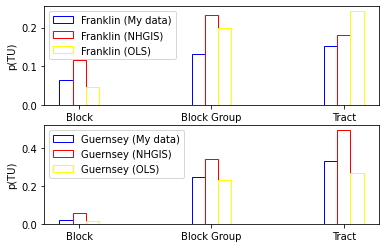

In [49]:
import matplotlib.pyplot as plt

labels = ['Block', 'Block Group', 'Tract']
x = np.arange(len(labels))  # the label locations
width = 0.1 # the width of the bars
fig, ax = plt.subplots(2)
colors = [(0, 0, 1, 1), (1, 0, 0, 1), (1, 1, 0, 1)]

## franklin
p_tu_1 = [p_tu_blk, p_tu_bg, p_tu_tr]
p_tu_2 = [p_tu_nhgis_blk, p_tu_nhgis_bg, p_tu_nhgis_tr]
p_tu_3 = [p_tu_ols_blk, p_tu_ols_bg, p_tu_ols_tr]

rects1 = ax[0].bar(x - width, p_tu_1, width, label='Franklin (My data)', color=(0,0,0,0), edgecolor=colors[0])
rects3 = ax[0].bar(x, p_tu_2, width, label='Franklin (NHGIS)', color=(0,0,0,0), edgecolor=colors[1])
rects2 = ax[0].bar(x + width, p_tu_3, width, label='Franklin (OLS)', color=(0,0,0,0), edgecolor=colors[2])

ax[0].set_ylabel('p(TU)')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

## guernsey
p_tu_1 = [p_tu_blk_g, p_tu_bg_g, p_tu_tr_g]
p_tu_2 = [p_tu_nhgis_blk_g, p_tu_nhgis_bg_g, p_tu_nhgis_tr_g]
p_tu_3 = [p_tu_ols_blk_g, p_tu_ols_bg_g, p_tu_ols_tr_g]

rects1 = ax[1].bar(x - width, p_tu_1, width, label='Guernsey (My data)', color=(0,0,0,0), edgecolor=colors[0])
rects3 = ax[1].bar(x, p_tu_2, width, label='Guernsey (NHGIS)', color=(0,0,0,0), edgecolor=colors[1])
rects2 = ax[1].bar(x + width, p_tu_3, width, label='Guernsey (OLS)', color=(0,0,0,0), edgecolor=colors[2])

ax[1].set_ylabel('p(TU)')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

plt.show()

#####**Impact of extents**

Read block and tract data

In [ ]:
!pip install geopandas
!pip install pysal

Franklin county

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_block = 'data/franklin/buildings/franklin_block10.json'
data_block = gpd.read_file(filename_block)
data_block['GEOID10'] = data_block['GEOID10'].astype(str)
data_block['BGID10'] = data_block['GEOID10'].str[:12]
data_block['TRACTID10'] = data_block['GEOID10'].str[:11]
data_block.columns

/content/gdrive/My Drive/Colab Notebooks/census_privacy


/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Index(['OBJECTID_1', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10',
       'GEOID10', 'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE',
       'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'PUMA',
       'Shape_Length', 'Shape_Area', 'BGID10', 'TRACTID10', 'geometry'],
      dtype='object')

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_tract = 'data/franklin/buildings/franklin_tract10.json'
data_tract = gpd.read_file(filename_tract)
data_tract['GEOID10'] = data_tract['GEOID10'].astype(str)
data_tract.columns

/content/gdrive/My Drive/Colab Notebooks/census_privacy


Index(['OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'Shape_Length', 'Shape_Area', 'geometry'],
      dtype='object')

Guernsey county

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_block_g = 'data/guernsey/buildings/guernsey_block10.json'
data_block_g = gpd.read_file(filename_block_g)
data_block_g['GEOID10'] = data_block_g['GEOID10'].astype(str)
data_block_g['BGID10'] = data_block_g['GEOID10'].str[:12]
data_block_g['TRACTID10'] = data_block_g['GEOID10'].str[:11]
data_block_g.columns

/content/gdrive/My Drive/Colab Notebooks/census_privacy


Index(['FID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'FUNCSTAT10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry', 'BGID10',
       'TRACTID10'],
      dtype='object')

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_tract_g = 'data/guernsey/buildings/guernsey_tract10.json'
data_tract_g = gpd.read_file(filename_tract_g)
data_tract_g['GEOID10'] = data_tract_g['GEOID10'].astype(str)
data_tract_g.columns

/content/gdrive/My Drive/Colab Notebooks/census_privacy


Index(['FID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'geometry'],
      dtype='object')

######**Continuous neighbors**

> Find blocks in the most populated tract (largest population density), and keep searching the neighbors based on Rook continuity until all blocks in the county are covered.



**Franklin county**

In [ ]:
total = hist1_tr.sum(axis=1).to_frame()
total["GEOID10"] = total.index.map(str)
total = total.rename(columns={total.columns[0]: "POP"})
total.index.name = None
data_tract_new = data_tract.merge(total[['GEOID10', 'POP']], how='left', on=['GEOID10'])
total.head()

,POP,GEOID10
39049000110,3316,39049000110
39049000120,3122,39049000120
39049000210,2889,39049000210
39049000220,3674,39049000220
39049000310,3047,39049000310


In [ ]:
data_tract_new["POP_DEN"] = data_tract_new["POP"] / data_tract_new["ALAND10"]
max_index = data_tract_new["POP_DEN"].idxmax()
max_id = data_tract_new.loc[max_index].at['GEOID10']
max_index, max_id

(232, '39049001810')

Group 1: Franklin County, my data

In [ ]:
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract)

tract_index = [max_index]
p_tu = []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract):
        flag = 1

    # create histogram
    tract_ids = data_tract["GEOID10"].iloc[tract_index]
    hist1_sub = hist1[hist1.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    hist2_sub = hist2[hist2.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    u = hist2_sub == 1  # uniques after noise injection
    n_u = np.unique(u.values, return_counts=True)[1][1]
    p_tu_all = n_tu / n_u   # frequency of finding the true uniques
    p_tu.append(p_tu_all)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
p_tu

[0.09090909090909091,
 0.037037037037037035,
 0.08430913348946135,
 0.08067729083665338,
 0.07761642463695544,
 0.07682659140796488,
 0.07269617276031644,
 0.06855032910579548,
 0.06486555371479547,
 0.0670926517571885,
 0.06607410580424074,
 0.06568958245466049]

Group 2: Franklin County, NHGIS data (2021-06-08)

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_block_OH.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis['TRACT'] = data_nhgis["gisjoin"].str.slice(8, 14)
data_nhgis['GEOID10'] = data_nhgis[['STATE', 'COUNTY', 'TRACT']].apply(lambda x: ''.join(x), axis=1)
data_nhgis = data_nhgis.set_index('GEOID10')
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_blk = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_blk = hist1_nhgis_blk.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_blk = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_blk = hist2_nhgis_blk.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract)

tract_index = [max_index]
p_tu_nhgis = []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract):
        flag = 1

    # create histogram
    tract_ids = data_tract["GEOID10"].iloc[tract_index]
    hist1_sub = hist1_nhgis_blk[hist1_nhgis_blk.index.astype(str).isin(tract_ids)].sort_index()
    hist2_sub = hist2_nhgis_blk[hist2_nhgis_blk.index.astype(str).isin(tract_ids)].sort_index()
    
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    u = hist2_sub == 1  # uniques after noise injection
    n_u = np.unique(u.values, return_counts=True)[1][1]
    p_tu_all = n_tu / n_u   # frequency of finding the true uniques
    p_tu_nhgis.append(p_tu_all)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
p_tu_nhgis

/content/gdrive/My Drive/Colab Notebooks/census_privacy


[0.2857142857142857,
 0.18032786885245902,
 0.16194331983805668,
 0.15,
 0.13799448022079117,
 0.13467132053519487,
 0.12461820403176542,
 0.1198201092194025,
 0.11827541827541828,
 0.11745886654478976,
 0.1163877417952619,
 0.115491452991453]

Group 3: Franklin County, OLS

In [ ]:
import geopandas as gpd
from pysal.lib import weights
import scipy.stats
from lib.topdown_ols import *
import math

eps = 17.14
delta = 1e-10
# rho = 1
rho = cdp2adp.cdp_rho(eps, delta)
f1, f2, f3, f4, f6, f7, f8, f9, f10, f11 = 165/4099*5/4097, 165/4099*9/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*21/4097, 165/4099*21/4097, 165/4099*5/4097, 165/4099*71/4097, 165/4099*3945/4097
A = strategy_mtx(rho, f1, f2, f3, f4, f6, f7, f8, f9, f10, f11)
W = workload_mtx_race()
var = (W @ np.linalg.inv(A.T @ A) @ W.T)[0, 0]
sigma = math.sqrt(var)

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract)

tract_index = [max_index]
p_tu_ols = []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract):
        flag = 1

    # create histogram
    tract_ids = data_tract["GEOID10"].iloc[tract_index]
    hist1_sub = hist1[hist1.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    
    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    p_tu_all = p3 * p4 / sum(probs)
    p_tu_ols.append(p_tu_all)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
p_tu_ols

(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)


[0.06103531147109589,
 0.038937975996685664,
 0.06625433181104087,
 0.056935311897547226,
 0.0543988962007172,
 0.052734718224194344,
 0.05097968539610275,
 0.05065221528823322,
 0.04959977832903994,
 0.04934788339876394,
 0.048293256507202426,
 0.04809997077232813]

**Guernsey county**

In [50]:
total = hist1_tr_g.sum(axis=1).to_frame()
total["GEOID10"] = total.index.map(str)
total = total.rename(columns={total.columns[0]: "POP"})
total.index.name = None
data_tract_new = data_tract_g.merge(total[['GEOID10', 'POP']], how='left', on=['GEOID10'])
total.head()

,POP,GEOID10
39059977100,4566.0,39059977100
39059977200,4779.0,39059977200
39059977300,3549.0,39059977300
39059977400,3607.0,39059977400
39059977500,3377.0,39059977500


In [51]:
data_tract_new["POP_DEN"] = data_tract_new["POP"] / data_tract_new["ALAND10"]
max_index = data_tract_new["POP_DEN"].idxmax()
max_id = data_tract_new.loc[max_index].at['GEOID10']
max_index, max_id

(8, '39059977500')

Group 4: Guernsey County, my data

In [53]:
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract_g)

tract_index = [max_index]
p_tu_g = []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract_g):
        flag = 1

    # create histogram
    tract_ids = data_tract_g["GEOID10"].iloc[tract_index]
    hist1_sub = hist1_g[hist1_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    hist2_sub = hist2_g[hist2_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    if len(np.unique(tu.values, return_counts=True)[1]) == 2:
        n_tu = np.unique(tu.values, return_counts=True)[1][1]
        u = hist2_sub == 1  # uniques after noise injection
        n_u = np.unique(u.values, return_counts=True)[1][1]
        p_tu_all = n_tu / n_u   # frequency of finding the true uniques
    else:
        p_tu_all = 0
    p_tu_g.append(p_tu_all)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
p_tu_g

[0, 0.0196078431372549, 0.017857142857142856, 0.02142857142857143]

Group 5: Guernsey County, NHGIS data (2021-06-08)

In [54]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_block_OH.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis['TRACT'] = data_nhgis["gisjoin"].str.slice(8, 14)
data_nhgis['GEOID10'] = data_nhgis[['STATE', 'COUNTY', 'TRACT']].apply(lambda x: ''.join(x), axis=1)
data_nhgis = data_nhgis.set_index('GEOID10')
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_blk = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_blk = hist1_nhgis_blk.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_blk = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_blk = hist2_nhgis_blk.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract_g)

tract_index = [max_index]
p_tu_nhgis_g = []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract_g):
        flag = 1

    # create histogram
    tract_ids = data_tract_g["GEOID10"].iloc[tract_index]
    hist1_sub = hist1_nhgis_blk[hist1_nhgis_blk.index.astype(str).isin(tract_ids)].sort_index()
    hist2_sub = hist2_nhgis_blk[hist2_nhgis_blk.index.astype(str).isin(tract_ids)].sort_index()
    
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    u = hist2_sub == 1  # uniques after noise injection
    n_u = np.unique(u.values, return_counts=True)[1][1]
    p_tu_all = n_tu / n_u   # frequency of finding the true uniques
    p_tu_nhgis_g.append(p_tu_all)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
p_tu_nhgis_g

/content/gdrive/My Drive/Colab Notebooks/census_privacy


[0.08823529411764706,
 0.06293706293706294,
 0.05904761904761905,
 0.05701078582434515]

Group 6: Guernsey County, OLS

In [55]:
import geopandas as gpd
from pysal.lib import weights
import scipy.stats
from lib.topdown_ols import *
import math

eps = 17.14
delta = 1e-10
# rho = 1
rho = cdp2adp.cdp_rho(eps, delta)
f1, f2, f3, f4, f6, f7, f8, f9, f10, f11 = 165/4099*5/4097, 165/4099*9/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*21/4097, 165/4099*21/4097, 165/4099*5/4097, 165/4099*71/4097, 165/4099*3945/4097
A = strategy_mtx(rho, f1, f2, f3, f4, f6, f7, f8, f9, f10, f11)
W = workload_mtx_race()
var = (W @ np.linalg.inv(A.T @ A) @ W.T)[0, 0]
sigma = math.sqrt(var)

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract_g)

tract_index = [max_index]
p_tu_ols_g = []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract_g):
        flag = 1

    # create histogram
    tract_ids = data_tract_g["GEOID10"].iloc[tract_index]
    hist1_sub = hist1_g[hist1_g.index.astype(str).str[:11].isin(tract_ids)].sort_index()
    
    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    p_tu_all = p3 * p4 / sum(probs)
    p_tu_ols_g.append(p_tu_all)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
p_tu_ols_g

(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)


[0.041146941111799895,
 0.02936509199902516,
 0.01744465218472444,
 0.015682139806798945]

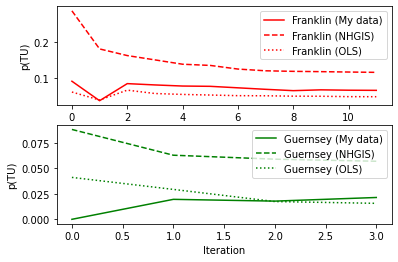

In [56]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2)

ax[0].plot(np.array(p_tu), color = 'r', label='Franklin (My data)')
ax[0].plot(np.array(p_tu_nhgis), color = 'r', label='Franklin (NHGIS)', linestyle='dashed')
ax[0].plot(np.array(p_tu_ols), color = 'r', label='Franklin (OLS)', linestyle='dotted')
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("p(TU)")
ax[0].legend()

ax[1].plot(np.array(p_tu_g), color = 'g', label='Guernsey (My data)')
ax[1].plot(np.array(p_tu_nhgis_g), color = 'g', label='Guernsey (NHGIS)', linestyle='dashed')
ax[1].plot(np.array(p_tu_ols_g), color = 'g', label='Guernsey (OLS)', linestyle='dotted')
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("p(TU)")
ax[1].legend()
plt.show()

######**Random**

Randomly sample 10% of the blocks (without replacement) and add  to the histogram.

In [57]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
import scipy.stats
from lib.topdown_ols import *
import math

filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_block_OH.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis['TRACT'] = data_nhgis["gisjoin"].str.slice(8, 14)
data_nhgis['BLOCK'] = data_nhgis["gisjoin"].str.slice(14, 18)
data_nhgis['GEOID10'] = data_nhgis[['STATE', 'COUNTY', 'TRACT', 'BLOCK']].apply(lambda x: ''.join(x), axis=1)
data_nhgis = data_nhgis.set_index('GEOID10')
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]

eps = 17.14
delta = 1e-10
# rho = 1
rho = cdp2adp.cdp_rho(eps, delta)
f1, f2, f3, f4, f6, f7, f8, f9, f10, f11 = 165/4099*5/4097, 165/4099*9/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*21/4097, 165/4099*21/4097, 165/4099*5/4097, 165/4099*71/4097, 165/4099*3945/4097
A = strategy_mtx(rho, f1, f2, f3, f4, f6, f7, f8, f9, f10, f11)
W = workload_mtx_race()
var = (W @ np.linalg.inv(A.T @ A) @ W.T)[0, 0]
sigma = math.sqrt(var)

data_block_new = data_block
N = int(0.1 * len(data_block_new))
block_ids_all = []
p_tu, p_tu_nhgis, p_tu_ols = [], [], []

while len(block_ids_all) < len(data_block):
    # sampling
    if len(data_block_new) >= N:
        block_ids = data_block_new["GEOID10"].sample(n=N)
    else: 
        block_ids = data_block_new["GEOID10"]
    block_ids_all = list(set(np.append(block_ids_all, block_ids)))
    data_block_new = data_block_new.loc[~data_block_new["GEOID10"].isin(block_ids)]    

    ## Group 1: Franklin County, my data
    # create histogram
    hist1_sub = hist1[hist1.index.astype(str).isin(block_ids_all)].sort_index()
    hist2_sub = hist2[hist2.index.astype(str).isin(block_ids_all)].sort_index()
    
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    u = hist2_sub == 1  # uniques after noise injection
    n_u = np.unique(u.values, return_counts=True)[1][1]
    p_tu_all = n_tu / n_u   # frequency of finding the true uniques
    p_tu.append(p_tu_all)

    ## Group 2: Franklin County, NHGIS data
    # create histogram
    nhgis_sub = data_nhgis[data_nhgis.index.astype(str).isin(block_ids_all)]
    hist1_nhgis = nhgis_sub[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
    hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                            'H72009_sf': '7'})
    hist2_nhgis = nhgis_sub[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
    hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                            'H72009_dp': '7'})
    
    # calculate p(TU)
    # find a true unique
    tu = (hist1_nhgis == hist2_nhgis) & (hist1_nhgis == 1) & (hist2_nhgis == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    # uniques after noise injection
    u = hist2_nhgis == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    # frequency of finding the true uniques
    p_tu_nhgis_all = n_tu / n_u
    p_tu_nhgis.append(p_tu_nhgis_all)

    ## Group 3: Franklin County, OLS
    hist1_sub = hist1[hist1.index.astype(str).isin(block_ids_all)]
    
    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    p_tu_all = p3 * p4 / sum(probs)
    p_tu_ols.append(p_tu_all)

p_tu, p_tu_nhgis, p_tu_ols

/content/gdrive/My Drive/Colab Notebooks/census_privacy
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)


([0.06652360515021459,
  0.0695742471443406,
  0.06869961444093936,
  0.06583818085668958,
  0.06491858743920491,
  0.06510555259890012,
  0.06557627636808315,
  0.06497665110073382,
  0.06571495988673903,
  0.06568958245466049,
  0.06568958245466049],
 [0.11414141414141414,
  0.12506380806533945,
  0.12289156626506025,
  0.1199065663119647,
  0.11652319966407726,
  0.11315742872321587,
  0.11315869631434664,
  0.11491181186531267,
  0.11370401238242647,
  0.11551613592648002,
  0.115491452991453],
 [0.045975228867429004,
  0.048336525946452234,
  0.04796449773046613,
  0.04857485056519497,
  0.04850859962953962,
  0.04866974678088221,
  0.04823596788311062,
  0.0481198885619103,
  0.04804945420516591,
  0.04809837618059358,
  0.04809997077232813])

In [58]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
import scipy.stats
from lib.topdown_ols import *
import math

filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_block_OH.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis['TRACT'] = data_nhgis["gisjoin"].str.slice(8, 14)
data_nhgis['BLOCK'] = data_nhgis["gisjoin"].str.slice(14, 18)
data_nhgis['GEOID10'] = data_nhgis[['STATE', 'COUNTY', 'TRACT', 'BLOCK']].apply(lambda x: ''.join(x), axis=1)
data_nhgis = data_nhgis.set_index('GEOID10')
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]

eps = 17.14
delta = 1e-10
# rho = 1
rho = cdp2adp.cdp_rho(eps, delta)
f1, f2, f3, f4, f6, f7, f8, f9, f10, f11 = 165/4099*5/4097, 165/4099*9/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*5/4097, 165/4099*21/4097, 165/4099*21/4097, 165/4099*5/4097, 165/4099*71/4097, 165/4099*3945/4097
A = strategy_mtx(rho, f1, f2, f3, f4, f6, f7, f8, f9, f10, f11)
W = workload_mtx_race()
var = (W @ np.linalg.inv(A.T @ A) @ W.T)[0, 0]
sigma = math.sqrt(var)

data_block_new = data_block_g
N = int(0.1 * len(data_block_new))
block_ids_all = []
p_tu_g, p_tu_nhgis_g, p_tu_ols_g = [], [], []

while len(block_ids_all) < len(data_block_g):
    # sampling
    if len(data_block_new) >= N:
        block_ids = data_block_new["GEOID10"].sample(n=N)
    else: 
        block_ids = data_block_new["GEOID10"]
    block_ids_all = list(set(np.append(block_ids_all, block_ids)))
    data_block_new = data_block_new.loc[~data_block_new["GEOID10"].isin(block_ids)]    

    ## Group 1: Guernsey County, my data
    # create histogram
    hist1_sub = hist1_g[hist1_g.index.astype(str).isin(block_ids_all)].sort_index()
    hist2_sub = hist2_g[hist2_g.index.astype(str).isin(block_ids_all)].sort_index()
    
    # calculate p(TU)
    tu = (hist1_sub == hist2_sub) & (hist1_sub == 1) & (hist2_sub == 1) # find a true unique
    if len(np.unique(tu.values, return_counts=True)[1]) == 2:
        n_tu = np.unique(tu.values, return_counts=True)[1][1]
        u = hist2_sub == 1  # uniques after noise injection
        n_u = np.unique(u.values, return_counts=True)[1][1]
        p_tu_all = n_tu / n_u   # frequency of finding the true uniques
    else:
        p_tu_all = 0
    p_tu_g.append(p_tu_all)

    ## Group 2: Guernsey County, NHGIS data
    # create histogram
    nhgis_sub = data_nhgis[data_nhgis.index.astype(str).isin(block_ids_all)]
    hist1_nhgis = nhgis_sub[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
    hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                            'H72009_sf': '7'})
    hist2_nhgis = nhgis_sub[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
    hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                            'H72009_dp': '7'})
    
    # calculate p(TU)
    # find a true unique
    tu = (hist1_nhgis == hist2_nhgis) & (hist1_nhgis == 1) & (hist2_nhgis == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    # uniques after noise injection
    u = hist2_nhgis == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    # frequency of finding the true uniques
    p_tu_nhgis_all = n_tu / n_u
    p_tu_nhgis_g.append(p_tu_nhgis_all)

    ## Group 3: Guernsey County, OLS
    hist1_sub = hist1_g[hist1_g.index.astype(str).isin(block_ids_all)]
    
    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    p_tu_all = p3 * p4 / sum(probs)
    p_tu_ols_g.append(p_tu_all)

p_tu_g, p_tu_nhgis_g, p_tu_ols_g

/content/gdrive/My Drive/Colab Notebooks/census_privacy
(1, 2016) (63, 2016) (2, 2016) (2, 2016) (8, 2016) (126, 2016) (126, 2016) (4, 2016) (252, 2016) (2016, 2016) (2600, 2016)


([0,
  0,
  0.02857142857142857,
  0.04,
  0.029850746268656716,
  0.025,
  0.02247191011235955,
  0.02830188679245283,
  0.024193548387096774,
  0.02142857142857143,
  0.02142857142857143],
 [0.034482758620689655,
  0.03389830508474576,
  0.05319148936170213,
  0.06097560975609756,
  0.05625,
  0.061381074168797956,
  0.05605381165919283,
  0.0611439842209073,
  0.058925476603119586,
  0.05736434108527132,
  0.05701078582434515],
 [0.01649862559830875,
  0.017814120414129435,
  0.01695373125788928,
  0.017400482981897693,
  0.01791176051223725,
  0.017668952434293048,
  0.016653868590520083,
  0.01612897495044969,
  0.015858109438564843,
  0.01571840123378209,
  0.015682139806798945])

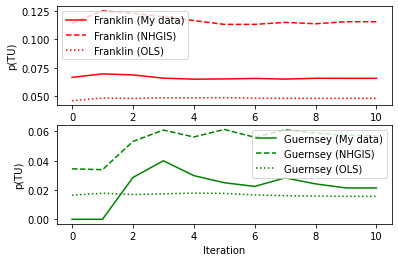

In [59]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2)

ax[0].plot(np.array(p_tu), color = 'r', label='Franklin (My data)')
ax[0].plot(np.array(p_tu_nhgis), color = 'r', label='Franklin (NHGIS)', linestyle='dashed')
ax[0].plot(np.array(p_tu_ols), color = 'r', label='Franklin (OLS)', linestyle='dotted')
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("p(TU)")
ax[0].legend()

ax[1].plot(np.array(p_tu_g), color = 'g', label='Guernsey (My data)')
ax[1].plot(np.array(p_tu_nhgis_g), color = 'g', label='Guernsey (NHGIS)', linestyle='dashed')
ax[1].plot(np.array(p_tu_ols_g), color = 'g', label='Guernsey (OLS)', linestyle='dotted')
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("p(TU)")
ax[1].legend()
plt.show()

####**More on cell uniqueness**
Some simulations to demonstrate how spatial scales affect the probability of finding a true unique. Two aspects of spatial scales are examined here: resolution and extent.

#####**Impact of privacy loss budget (rho)**

For block level data, change epsilon from 1 to 20 while using the same allocation budget.

In [ ]:
import scipy.stats
import math
import numpy as np

delta = 10 ** (-10)
hist1 = pd.crosstab(data_people.GEOID10, data_people.race)
column_values = hist1[hist1.columns].values.ravel()
A = pd.unique(column_values)

p_tu_rho = []
for k in np.arange(0.5, 21, 0.5):
    rho = k * 9/4097
    sigma = math.sqrt(1 / (2 * rho))

    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1 == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)

    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1 == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    p_tu = p3 * p4 / sum(probs)
    p_tu_rho.append(p_tu)

p_tu_rho

Compare with Guernsey county.

In [ ]:
import scipy.stats
import math
import numpy as np

delta = 10 ** (-10)
hist1 = pd.crosstab(data_people_g.GEOID10, data_people_g.race)
column_values = hist1[hist1.columns].values.ravel()
A = pd.unique(column_values)

p_tu_rho_g = []
for k in np.arange(0.5, 21, 0.5):
    rho = k * 9/4097
    sigma = math.sqrt(1 / (2 * rho))

    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1 == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)

    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1 == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    p_tu = p3 * p4 / sum(probs)
    p_tu_rho_g.append(p_tu)

p_tu_rho_g

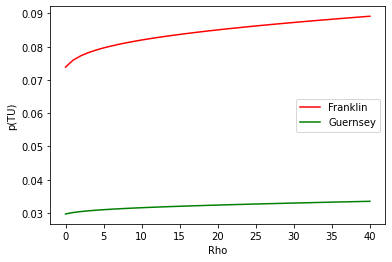

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.array(p_tu_rho), color = 'r', label='Franklin')
plt.plot(np.array(p_tu_rho_g), color = 'g', label='Guernsey')
plt.xlabel("Rho")
plt.ylabel("p(TU)")
plt.legend()
plt.show()

**Something to do with population density**

The trend above can potentially be explained by the population distribution in the county. As the iteration increases, more sparse blocks are added, and the histogram is more concentrated around zero. This can lead to the sharpe decrease in $p(TU)$.

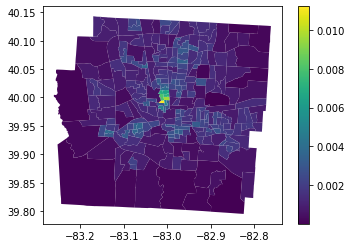

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
data_tract_new.plot(column='POP_DEN', ax=ax, legend=True)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


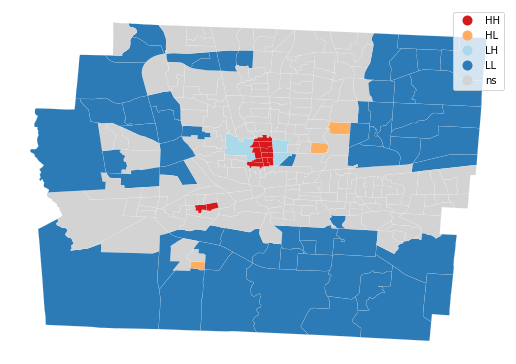

In [ ]:
from splot.esda import lisa_cluster
from pysal.lib import weights
from pysal.explore import esda

data_tract_new['POP_DEN'] = data_tract_new['POP_DEN'].fillna(0)
# Generate W from the GeoDataFrame
w = weights.Queen.from_dataframe(data_tract_new)
# Row-standardization
w.transform = 'R'

moran_loc = esda.moran.Moran_Local(data_tract_new['POP_DEN'].values, w)
lisa_cluster(moran_loc, data_tract_new, p=0.05, figsize = (9,9))
plt.show()